# PAOS

This notebook demonstrates the basic functionality of PAOS.

Select the desired example configuration desired below

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os, sys, time
from pathlib import Path
import importlib

# Add to PYTHONPATH the path to local libraries
paospath = "~/git/PAOS"
if not os.path.expanduser(paospath) in sys.path:
    sys.path.append( os.path.expanduser(paospath) )
    import paos
else:
    importlib.reload(paos)

## Inputs

Define lens file to use

In [2]:
OpticalPrescription = 'lens_file.ini'
OpticalPrescription = 'lens_file_temp.ini'
#OpticalPrescription = 'lens_file_TA_Ground.ini'


OpticalPrescriptionFile = os.path.join(paospath, 'lens data', OpticalPrescription)

# Parse lens file
pup_diameter, parameters, wavelengths, fields, opt_chain_list = paos.ParseConfig(OpticalPrescriptionFile)


## Ray tracing
Implement a full raytracing. For diagnostic purposes.

In [3]:
#raytracelist = paos.raytrace(fields[0], opt_chain, y=0.)
raytracelist = paos.raytrace({'ut':0, 'us':0}, opt_chain_list[0], y=-0.0)
for item in raytracelist:
    print(item)

S02 - LOS tilt        y:  0.000mm ut: 1.745e-03 rad x:  0.000mm us: 0.000e+00 rad
S03 - Move to M1      y:500.000mm ut: 1.745e-03 rad x:  0.000mm us: 0.000e+00 rad
S04 - M1              y: 49.136mm ut: 4.294e-01 rad x:  0.000mm us: 0.000e+00 rad
S05 - M2              y: 24.559mm ut:-1.846e-02 rad x:  0.000mm us: 0.000e+00 rad
S06 - FOCUS           y: 19.855mm ut:-1.846e-02 rad x:  0.000mm us: 0.000e+00 rad
S07 - M3              y: 19.855mm ut: 9.637e-02 rad x:  0.000mm us: 0.000e+00 rad
S08 - Ray Centering   y: -0.018mm ut:-6.050e-05 rad x:  0.000mm us: 0.000e+00 rad
S09 - Move to M4      y: -0.006mm ut:-6.050e-05 rad x:  0.000mm us: 0.000e+00 rad
S10 - x tilt - M4     y: -0.009mm ut:-1.124e+00 rad x:  0.000mm us: 0.000e+00 rad
S11 - M4              y: -0.009mm ut: 1.124e+00 rad x:  0.000mm us: 0.000e+00 rad
S12 - x tilt - M4     y:  0.000mm ut: 6.050e-05 rad x:  0.000mm us: 0.000e+00 rad
S13 - exit pupil      y:  0.064mm ut: 6.050e-05 rad x:  0.000mm us: 0.000e+00 rad
S16 - M7        

In [4]:
start_time = time.time()
print('Start POP...')

retval = paos.run(pup_diameter, 1.0e-6 * wavelengths[0], 
                  parameters['grid_size'], parameters['zoom'],
                 fields[0], opt_chain_list[0])

end_time = time.time()
print('POP completed in {:6.1f}s'.format(end_time-start_time))

Start POP...
POP completed in    1.3s


## Plot results

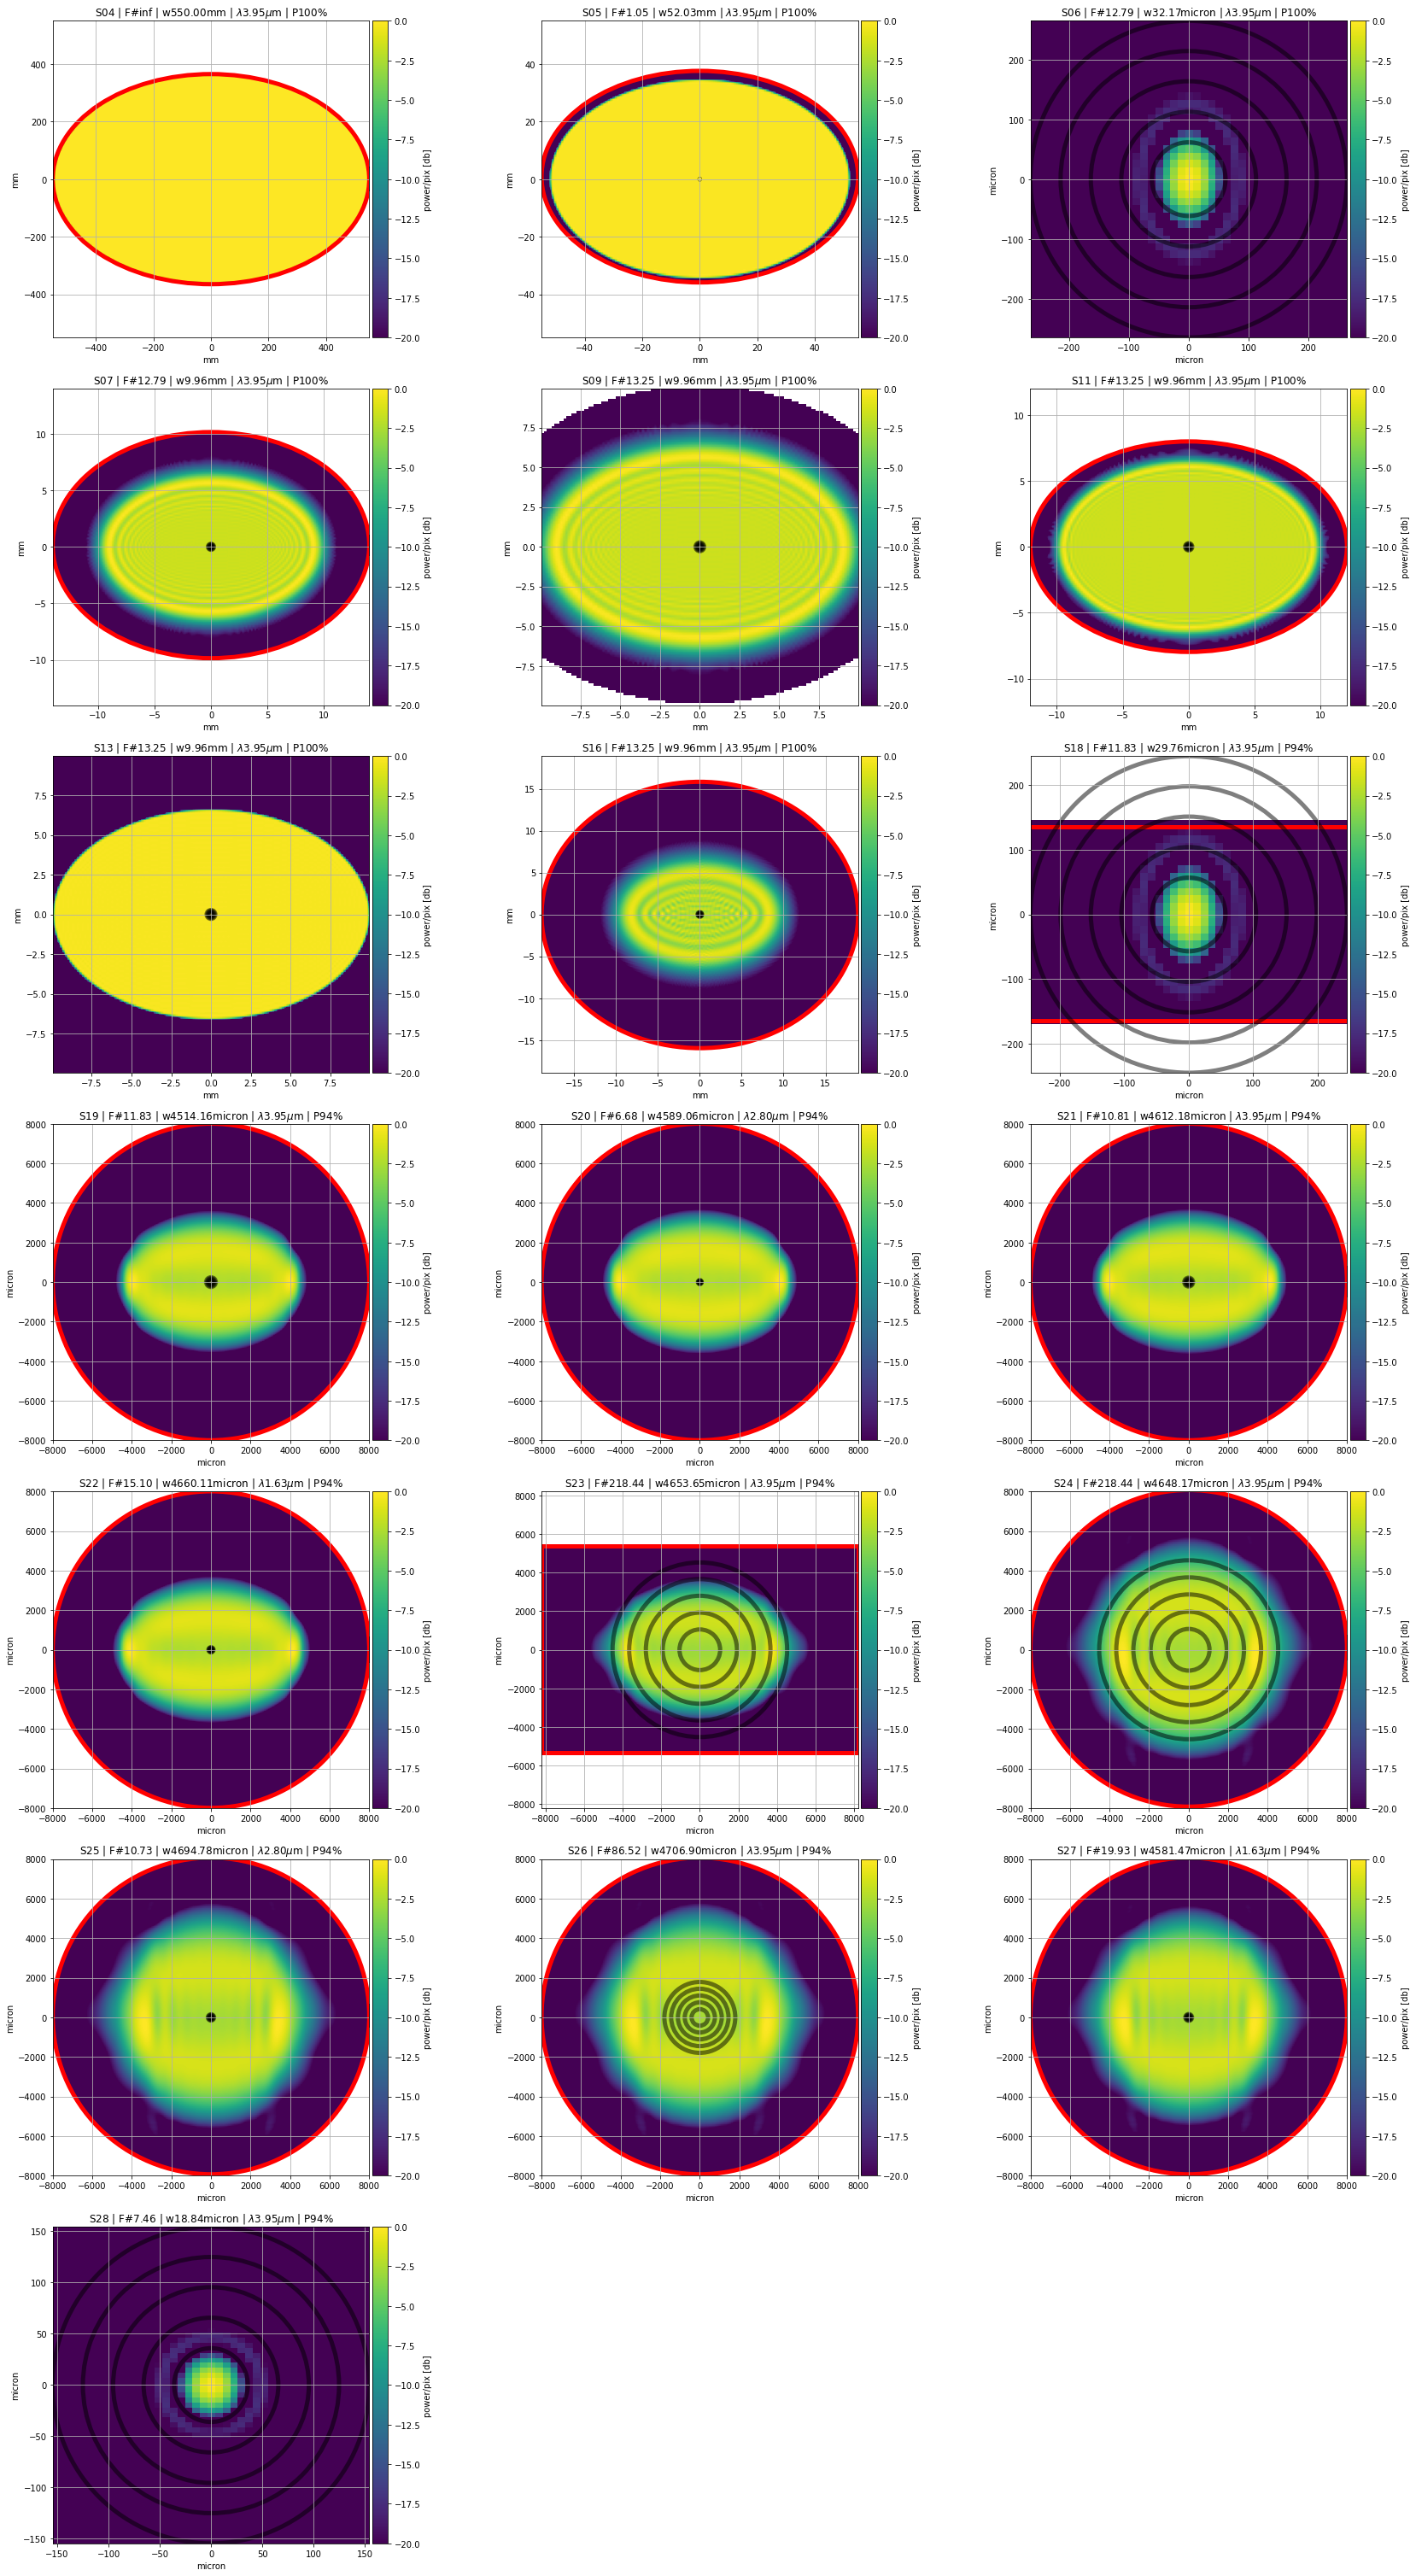

In [5]:
plots_dir = './plots'
Path(plots_dir).mkdir(parents=True, exist_ok=True)
figname = os.path.join(plots_dir, ''.join([OpticalPrescription, '_', str(1.0e-6 * wavelengths[0]), '.png']))

paos.plot_pop(retval, ima_scale='log', ncols=3, figname=None)#, surface_zoom={23:5})

# Run multiple POP simulations in parallel

This section demonstrates performing multiple POP simulations using parallel threads.

# Save results

This section demonstrates saving your results. 
The results are saved in .h5 format.

The saving routine are very flexible: you can either 
- save everything in your results (wfo, dx, dx, apertures...)
- or just a selection of things that you need (just the wfo, or whatever list of things)

1) This is how to save your output if you simulated just one POP realisation. 

2) This is how to save your output if you simulated more than one POP realisation. 